# DDPM ELBO: definition, derivation, computation & visualization (MNIST)

**Goal:** Understand the ELBO used in Denoising Diffusion Probabilistic Models (DDPMs) by:
- writing the ELBO and identifying its terms (reconstruction, prior-matching, denoising/consistency),
- deriving the closed-form KL expressions we use in practice,
- computing those terms numerically on MNIST samples,
- visualizing the noise schedule, noisy images across time, and ELBO term magnitudes (2D + 3D plots).

We will follow the common DDPM / Ho et al. (2020) parameterization where the model predicts the noise $\epsilon_\theta(x_t, t)$ and the forward noising is:
$$
q(x_t \mid x_0) = \mathcal{N}\big(x_t; \sqrt{\bar\alpha_t} x_0, (1 - \bar\alpha_t) I\big),
$$
with $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{s=1}^t \alpha_s$.

The ELBO (negative loss to minimize) decomposes into time-step KLs and a reconstruction term; in practice we optimize a simplified denoising loss equivalent to the ELBO under parameterization.


# Definitions & short derivation (math)

**Forward (noising) process:** For $t=1,\dots,T$ we define
$$
q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_{t-1}, \beta_t I)
$$
with $\alpha_t = 1-\beta_t$, and
$$
q(x_t \mid x_0) = \mathcal{N}\big(x_t; \sqrt{\bar\alpha_t} x_0,\ (1-\bar\alpha_t) I\big)
$$
where $\bar\alpha_t = \prod_{s=1}^t \alpha_s$.

**Reverse (generative) process (learned):**
$$
p_\theta(x_{t-1}\mid x_t) = \mathcal{N}\big(x_{t-1};\ \mu_\theta(x_t,t), \Sigma_\theta(x_t,t)\big)
$$

**ELBO (variational lower bound) decomposition** for latent chain $x_0, x_1,\dots,x_T$:
$$
\mathcal{L} = \mathbb{E}_q\Big[-\log p_\theta(x_0 \mid x_1) - \sum_{t=2}^{T} \log \frac{p_\theta(x_{t-1}\mid x_t)}{q(x_{t-1}\mid x_t,x_0)} - \log \frac{p_\theta(x_T)}{q(x_T\mid x_0)}\Big]
$$

This breaks into practical terms:

- **Reconstruction term** (often $t=1$ term): $-\log p_\theta(x_0\mid x_1)$ — how well model reconstructs $x_0$ from $x_1$.
- **Denoising / consistency terms** (sum of KLs): for each $t$, you get a KL between Gaussian distributions:
  $$ \mathrm{KL}\big(q(x_{t-1}\mid x_t,x_0) \,\|\, p_\theta(x_{t-1}\mid x_t)\big). $$
  Because both are Gaussians, there is a closed-form expression for that KL.
- **Prior matching** (final latent): $\mathrm{KL}\big(q(x_T\mid x_0)\,\|\, p(x_T)\big)$; typically $p(x_T)=\mathcal{N}(0,I)$.

**Practical single-step denoising loss (common):** parameterize $\mu_\theta$ via predicted noise:
$$
\epsilon_\theta(x_t,t) \approx \epsilon \quad\text{(true noise used to produce } x_t)
$$
Then the simplified training objective is the MSE:
$$
\mathcal{L}_\text{simple} = \mathbb{E}_{x_0,\epsilon,t}\left[\|\epsilon - \epsilon_\theta(x_t,t)\|^2\right]
$$
which is proportional to the true ELBO under the Gaussian assumptions and appropriate weighting. We'll compute both the closed-form KL terms and the simple MSE to see how they compare numerically.


In [1]:
# Python cell: imports + small utilities
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.61MB/s]


Batch shape: torch.Size([128, 1, 28, 28])


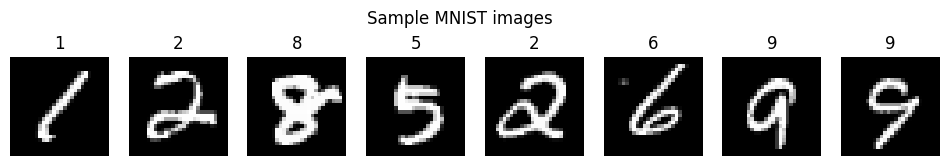

In [2]:
# Python cell: load MNIST and show samples
transform = transforms.Compose([
    transforms.ToTensor(),               # in [0,1]
    transforms.Normalize((0.5,), (0.5,)) # to [-1,1] for tanh-style models
])

mnist = torchvision.datasets.MNIST(root="mnist_data", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)

# show a few
imgs, labels = next(iter(loader))
print("Batch shape:", imgs.shape)
fig,axes = plt.subplots(1,8,figsize=(12,2))
for i in range(8):
    ax = axes[i]
    ax.imshow((imgs[i].cpu().squeeze(0)*0.5 + 0.5), cmap='gray')
    ax.axis('off')
    ax.set_title(int(labels[i].item()))
plt.suptitle("Sample MNIST images")
plt.show()


# Beta schedule and key closed-form quantities

We will use a linear beta schedule:
$$
\beta_t \in (0,1),\quad \alpha_t = 1-\beta_t,\quad \bar\alpha_t=\prod_{s=1}^t\alpha_s.
$$

Key closed-form expectations used in sampling and the ELBO:
- $q(x_t\mid x_0)=\mathcal N(x_t;\sqrt{\bar\alpha_t}x_0,(1-\bar\alpha_t)I)$
- We will need $\sqrt{\bar\alpha_t}$ and $\sqrt{1-\bar\alpha_t}$ and the posterior mean/variance for $q(x_{t-1}\mid x_t,x_0)$ (Gaussian).


T = 100
beta[0:5] = [0.0001     0.00030101 0.00050202 0.00070303 0.00090404]
alpha_bars[0:5] = [0.9999     0.99959904 0.9990972  0.9983948  0.9974922 ]


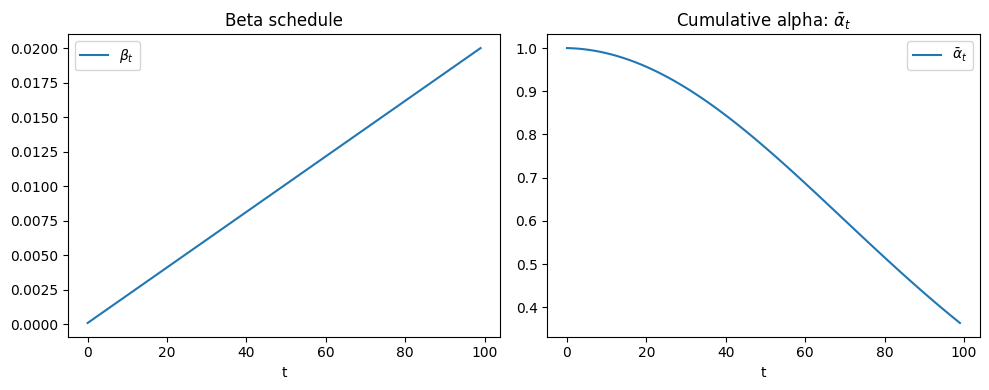

In [4]:
import matplotlib.pyplot as plt
import torch

# Python cell: prepare betas, alphas, and show schedule
T = 100  # number of diffusion steps for analysis (can be 100 or 1000 in real research)
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float64)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

# useful scalars
betas = betas.float()
alphas = alphas.float()
alpha_bars = alpha_bars.float()
sqrt_alpha_bars = torch.sqrt(alpha_bars)
sqrt_one_minus_alpha_bars = torch.sqrt(1.0 - alpha_bars)

print("T =", T)
print("beta[0:5] =", betas[:5].numpy())
print("alpha_bars[0:5] =", alpha_bars[:5].numpy())

# 2D plots: betas and alpha_bar
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(betas.numpy(), label=r'$\beta_t$')
plt.title(r'Beta schedule')
plt.xlabel('t'); plt.legend()

plt.subplot(1,2,2)
plt.plot(alpha_bars.numpy(), label=r'$\bar{\alpha}_t$')
plt.title(r'Cumulative alpha: $\bar{\alpha}_t$')
plt.xlabel('t'); plt.legend()

plt.tight_layout()
plt.show()


# Posterior $q(x_{t-1}\mid x_t,x_0)$ (closed-form) and Gaussian KL

The posterior (because forward transitions are Gaussian) is:
$$
q(x_{t-1}\mid x_t, x_0) = \mathcal{N}\big(x_{t-1};\ \tilde\mu_t(x_t, x_0),\ \tilde\beta_t I\big)
$$
with
$$
\tilde\beta_t = \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t} \beta_t,
\qquad
\tilde\mu_t(x_t,x_0) = \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1-\bar\alpha_t} x_0 + \frac{\sqrt{\alpha_t}(1-\bar\alpha_{t-1})}{1-\bar\alpha_t} x_t.
$$

Because both $q(\cdot)$ and $p_\theta(\cdot)$ are Gaussians, the KL per step is (closed-form):
$$
\mathrm{KL}(\mathcal{N}(\mu_q,\sigma_q^2 I)\ \|\ \mathcal{N}(\mu_p,\sigma_p^2 I))
= \frac{1}{2}\Big[\frac{\|\mu_p-\mu_q\|^2}{\sigma_p^2} + d\Big(\frac{\sigma_q^2}{\sigma_p^2} - 1 - \log\frac{\sigma_q^2}{\sigma_p^2}\Big)\Big],
$$
where $d$ is dimensionality per example (e.g. 28*28 for MNIST).


In [5]:
# Python cell: q_sample, q_posterior, and gaussian_KL (per example)
def q_sample(x0, t, noise=None):
    """
    Sample x_t ~ q(x_t | x_0) in closed form:
    x_t = sqrt(alpha_bar_t) * x0 + sqrt(1-alpha_bar_t) * eps
    t is integer tensor or scalar (0-indexed for arrays)
    """
    if noise is None:
        noise = torch.randn_like(x0)
    a_bar = sqrt_alpha_bars[t].to(x0.device).view(-1, *([1]* (x0.ndim-1)))
    b_sqrt = sqrt_one_minus_alpha_bars[t].to(x0.device).view(-1, *([1]* (x0.ndim-1)))
    return a_bar * x0 + b_sqrt * noise, noise

def q_posterior_mean_var(x_t, x0, t):
    """
    Compute mean and variance of q(x_{t-1} | x_t, x0) given indices t (1..T-1).
    t is a 1D tensor of timesteps (1-indexed in math, but we'll use 0-index arrays).
    Returns mean (B,C,H,W) and variance scalar per t.
    """
    # make t scalar or tensor
    t = t.long()
    # compute tilde_beta_t for each t: \tilde\beta_t = beta_t * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)
    one_minus_alpha_bars = (1.0 - alpha_bars)
    one_minus_alpha_bars = one_minus_alpha_bars.to(x0.device)
    denom = one_minus_alpha_bars[t]
    numer = (1.0 - alpha_bars[t-1]) if (t>0).all() else one_minus_alpha_bars[t-1]  # safe but t vector ok
    # vectorized:
    t_minus1 = (t-1).clamp(min=0)
    tilde_betas = betas[t] * (1.0 - alpha_bars[t_minus1]) / (1.0 - alpha_bars[t])
    tilde_vars = tilde_betas.to(x0.device)  # scalar per t

    # compute coefficients for mean
    coef1 = (torch.sqrt(alpha_bars[t_minus1]) * betas[t]) / (1.0 - alpha_bars[t])
    coef2 = (torch.sqrt(alphas[t]) * (1.0 - alpha_bars[t_minus1])) / (1.0 - alpha_bars[t])
    coef1 = coef1.to(x0.device).view(-1,1,1,1)
    coef2 = coef2.to(x0.device).view(-1,1,1,1)
    mean = coef1 * x0 + coef2 * x_t
    return mean, tilde_vars

def gaussian_kl(mu_q, var_q, mu_p, var_p):
    """
    Compute KL(N(mu_q,var_q) || N(mu_p,var_p)) per example, var_* scalars.
    mu_* tensors are (B, D) flattened or (B, C, H, W) shapes.
    Returns a per-batch-element KL (not averaged).
    """
    # flatten dims per example
    B = mu_q.shape[0]
    d = float(np.prod(mu_q.shape[1:]))
    mu_q_f = mu_q.view(B, -1)
    mu_p_f = mu_p.view(B, -1)
    var_q = float(var_q)
    var_p = float(var_p)
    sqdiff = ((mu_p_f - mu_q_f)**2).sum(dim=1)  # per example
    kl = 0.5 * ( sqdiff / var_p + d * (var_q/var_p - 1.0 - math.log(var_q/var_p)) )
    return kl


# Practical training objective (noise-prediction MSE)

Under common parameterization the model learns $\epsilon_\theta(x_t,t)$, and the simple loss is:
$$
\mathcal{L}_\text{simple} = \mathbb{E}_{x_0,\epsilon,t}\left[\|\epsilon - \epsilon_\theta(x_t,t)\|^2\right].
$$

This is simple to compute: sample $t\sim\text{Uniform}\{1,\dots,T\}$, sample $\epsilon\sim\mathcal N(0,I)$,
construct $x_t = \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon$, then compute MSE between $\epsilon$ and model prediction.

For demonstration we'll use a tiny dummy $\epsilon_\theta$ (an untrained conv net) and compute the MSE and the closed-form KL terms to compare magnitudes.


In [8]:
import torch
import torch.nn as nn
import numpy as np

# --------------------------------------
# Tiny epsilon-net (dummy, untrained)
# --------------------------------------
class TinyEpsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, 1, 1), nn.ReLU(),
            nn.Conv2d(16, 1, 3, 1, 1)
        )
    def forward(self, x, t=None):
        return self.net(x)

eps_net = TinyEpsNet().to(device)
mse = nn.MSELoss(reduction='none')


# --------------------------------------
# Load MNIST batch
# --------------------------------------
imgs, _ = next(iter(loader))
imgs = imgs.to(device)[:32]
B = imgs.shape[0]

print("Using batch size:", B, "example dims (C,H,W):", imgs.shape[1:])

# timesteps
inspect_ts = [0, 4, 9, 24, 49, 74, 99]
inspect_ts = torch.tensor(inspect_ts, device=device)

kl_list = []
mse_list = []

for t in inspect_ts:
    t_idx = t.item()

    x_t, true_eps = q_sample(imgs, t_idx)
    x_t, true_eps = x_t.to(device), true_eps.to(device)

    pred_eps = eps_net(x_t)

    per_example_mse = (
        mse(pred_eps, true_eps)
        .view(B, -1)
        .mean(dim=1)
        .detach()
        .cpu()
        .numpy()
    )

    # --- Fix: convert t to CPU for indexing ---
    t_cpu = torch.tensor([t_idx], dtype=torch.long, device='cpu')

    if t_idx == (T - 1):
        var_q = float(1.0 - alpha_bars[t_idx].item())
        mu_q = (sqrt_alpha_bars[t_idx].item()) * imgs
        mu_q = mu_q.to(device)

        kl_vals = (
            gaussian_kl(mu_q, var_q, torch.zeros_like(mu_q), 1.0)
            .detach()
            .cpu()
            .numpy()
        )
    else:
        # FIX: index scheduling tensors with CPU index
        mean_q, var_q = q_posterior_mean_var(x_t, imgs, t_cpu)
        mu_q = mean_q
        var_q = float(var_q.cpu().numpy()[0])

        kl_vals = (
            gaussian_kl(mu_q, var_q, torch.zeros_like(mu_q), 1.0)
            .detach()
            .cpu()
            .numpy()
        )

    kl_list.append(kl_vals.mean())
    mse_list.append(per_example_mse.mean())

    print(
        f"t={t_idx:3d}: mean MSE (eps pred) = {per_example_mse.mean():.6f}, "
        f"mean KL (example) = {np.mean(kl_vals):.6f}"
    )

kl_arr = np.array(kl_list)
mse_arr = np.array(mse_list)

print("KL:", kl_arr)
print("MSE:", mse_arr)


Using batch size: 32 example dims (C,H,W): torch.Size([1, 28, 28])
t=  0: mean MSE (eps pred) = 1.002810, mean KL (example) = 4663.796387
t=  4: mean MSE (eps pred) = 1.012579, mean KL (example) = 2891.850098
t=  9: mean MSE (eps pred) = 1.003333, mean KL (example) = 2506.552734
t= 24: mean MSE (eps pred) = 1.009076, mean KL (example) = 2083.779785
t= 49: mean MSE (eps pred) = 1.021395, mean KL (example) = 1799.326416
t= 74: mean MSE (eps pred) = 1.021408, mean KL (example) = 1639.505127
t= 99: mean MSE (eps pred) = 1.026308, mean KL (example) = 166.031647
KL: [4663.7964  2891.85    2506.5527  2083.7798  1799.3264  1639.5051
  166.03165]
MSE: [1.0028098 1.0125794 1.0033333 1.0090761 1.0213947 1.0214081 1.0263078]


# Interpretation of printed values

For each inspected timestep $t$ we printed:
- **mean MSE (eps pred)**: average per-example MSE between the true noise $\epsilon$ that generated $x_t$ and the network's predicted $\epsilon_\theta(x_t,t)$. This is the *practical* training signal (simple loss).
- **mean KL (example)**: example magnitude of KL terms for the prior/predictive posterior; these tell you how much each time step contributes to the ELBO if the reverse model does not match the true posterior.

Typically, the simple MSE loss is used because it is proportional to the weighted sum of these KLs under the Gaussian parameterization.


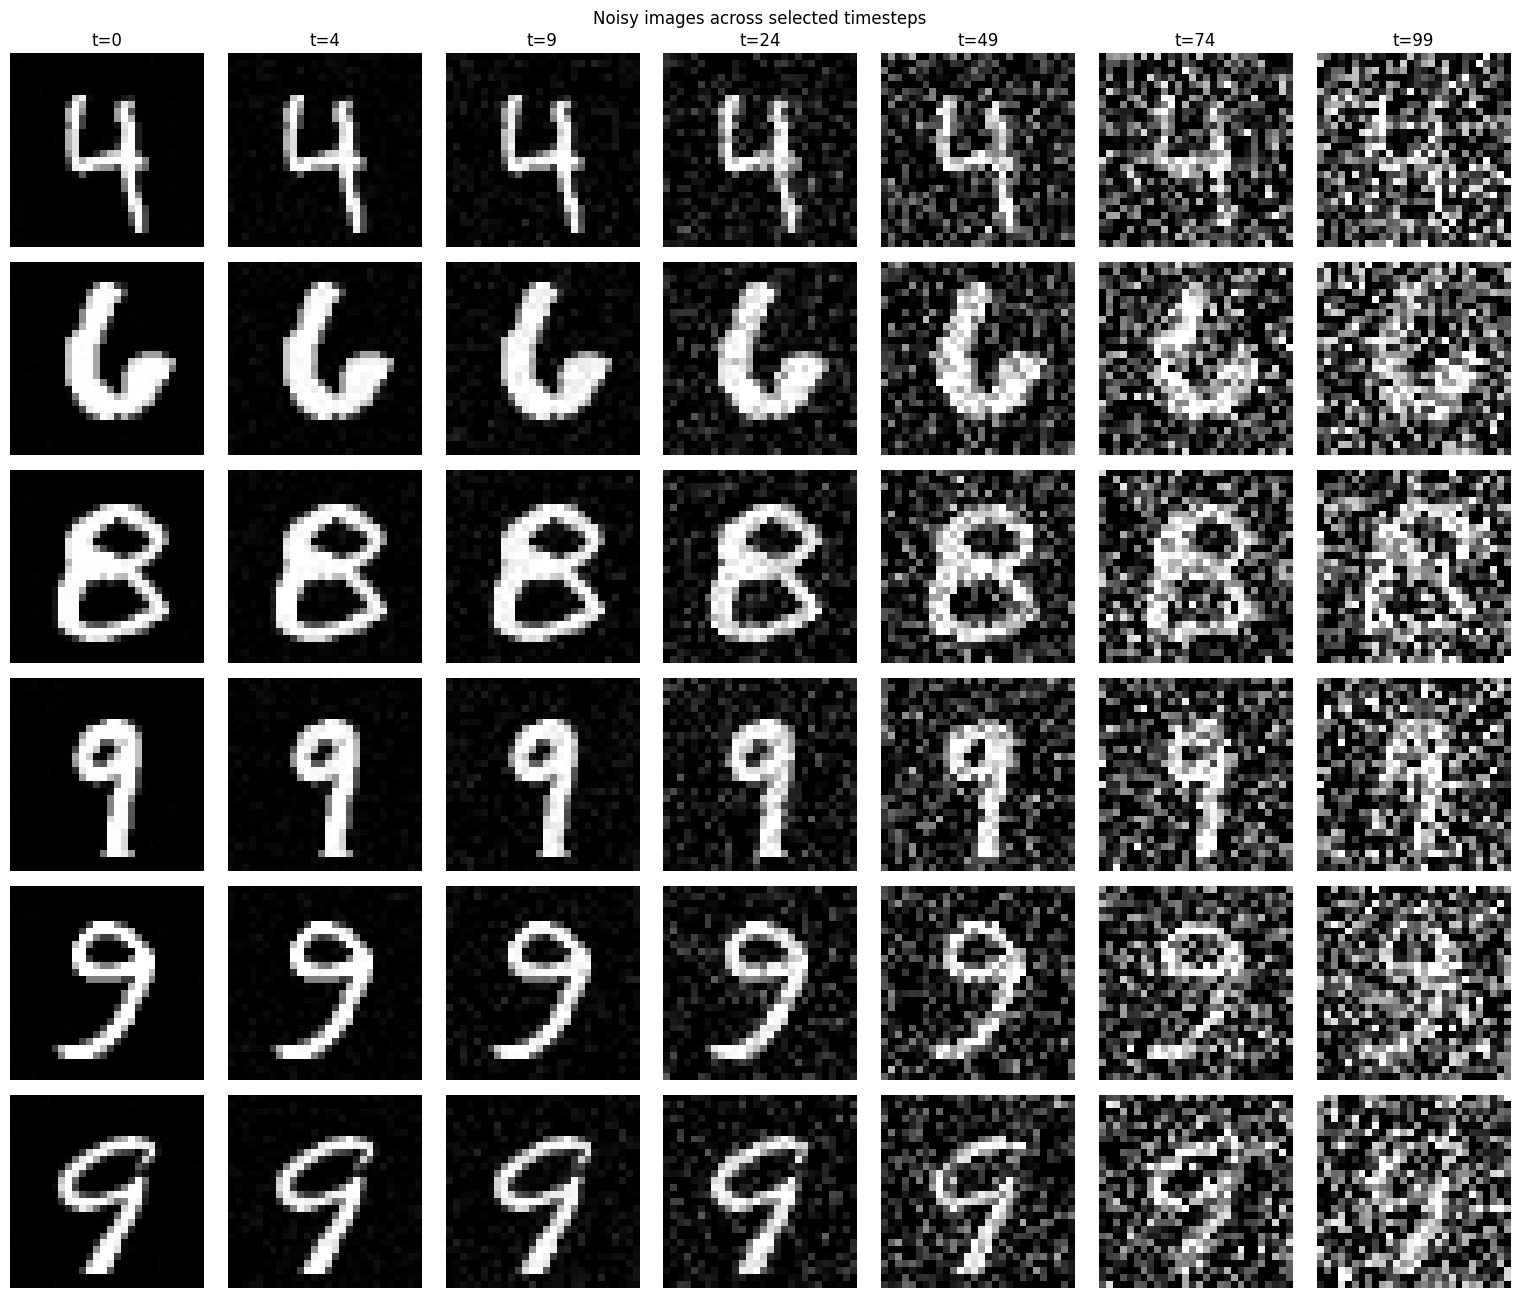

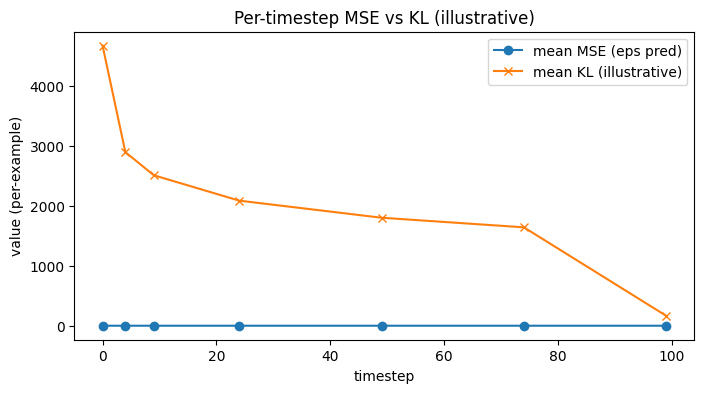

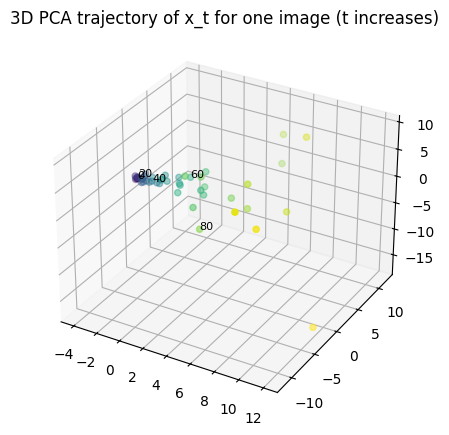

In [9]:
# Python cell: Visualizations (noisy chains + ELBO term plots + PCA 3D)
# 1) Show noisy chains for a few images across time
n_show = 6
sample_imgs = imgs[:n_show].cpu()
fig, axes = plt.subplots(n_show, len(inspect_ts), figsize=(2.2*len(inspect_ts), 2.2*n_show))
for i in range(n_show):
    for j, t in enumerate(inspect_ts):
        x_t, _ = q_sample(sample_imgs.to(device), int(t.item()))
        im = (x_t[0].cpu().squeeze(0)*0.5 + 0.5).numpy() if False else (x_t[i].cpu().squeeze(0)*0.5 + 0.5).numpy()
        axes[i,j].imshow(im, cmap='gray', vmin=0, vmax=1)
        if i==0:
            axes[i,j].set_title(f"t={int(t.item())}")
        axes[i,j].axis('off')
plt.suptitle("Noisy images across selected timesteps")
plt.tight_layout()
plt.show()

# 2) ELBO term style plot: MSE vs timestep (for inspected ones)
plt.figure(figsize=(8,4))
plt.plot([int(t.item()) for t in inspect_ts], mse_arr, marker='o', label='mean MSE (eps pred)')
plt.plot([int(t.item()) for t in inspect_ts], kl_arr, marker='x', label='mean KL (illustrative)')
plt.xlabel('timestep')
plt.ylabel('value (per-example)')
plt.legend()
plt.title('Per-timestep MSE vs KL (illustrative)')
plt.show()

# 3) PCA 3D: flatten several x_t for a chosen image and show trajectory in PCA space
# collect x_t for one image across all timesteps (use reduced set for speed)
img0 = imgs[0:1].to(device)
collect = []
ts_for_traj = list(range(0, T, max(1, T//50)))  # ~50 points
for t in ts_for_traj:
    x_t, _ = q_sample(img0, t)
    collect.append(x_t.view(1,-1).cpu().numpy())
all_pts = np.vstack(collect)  # shape (n_points, D)
pca = PCA(n_components=3)
proj = pca.fit_transform(all_pts)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(proj[:,0], proj[:,1], proj[:,2], c=np.linspace(0,1,len(proj)), cmap='viridis')
for i,p in enumerate(proj):
    if i % 10 == 0: ax.text(p[0], p[1], p[2], str(ts_for_traj[i]), size=8)
ax.set_title('3D PCA trajectory of x_t for one image (t increases)')
plt.show()


# Summary & next steps

- We defined the DDPM forward process and the ELBO decomposition into reconstruction, denoising (KL) and prior-matching terms.
- We derived the posterior $q(x_{t-1}\mid x_t,x_0)$ (closed-form), and used the Gaussian KL formula to compute per-step KL magnitudes (illustrative).
- We computed the simple noise-prediction MSE (practical training loss) and compared magnitudes to KL terms on MNIST examples.
- Visualizations:
  - Beta schedule and $\bar\alpha_t$,
  - noisy image chains across timesteps,
  - comparison of MSE vs (illustrative) KL values,
  - 3D PCA trajectory of a single image as it diffuses.

**Next steps if you want to continue:**
- Implement a full noise-prediction network conditioned on timestep (positional embedding for $t$) and train with the simple MSE loss — then compute the true ELBO using your trained $\mu_\theta$ (via $\epsilon_\theta$).
- Compare weighted ELBO vs simple MSE by computing exact closed-form step KLs where $p_\theta$ uses the learned mean.
- Visualize per-class differences, sample quality, FID, etc.
